In [48]:
# !pip install torchsummary

In [49]:
import torch
import os
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.torch_version
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall

import cv2
from joblib import Parallel, delayed

from torch.cuda.amp import GradScaler, autocast


In [50]:
import torch
print(torch.__version__)

2.3.1+cu121


In [51]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [52]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
main_path = '/kaggle/input/isic-2024-challenge' if iskaggle else 'data/isic-2024-challenge'

In [53]:
train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv' if iskaggle else 'data/isic-2024-challenge/train-metadata.csv'
test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv' if iskaggle else 'data/isic-2024-challenge/test-metadata.csv'

train_metadata_df = pd.read_csv(train_metadata_path)
test_metadata_df = pd.read_csv(test_metadata_path)

print(len(train_metadata_df))

C:\Users\abdfa\AppData\Local\Temp\ipykernel_23824\3275392473.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv(train_metadata_path)


401059


In [54]:
import sklearn.model_selection as train_test_split

train_size = 0.8
# Splitting the train dataset into positive and negative samples and saving them in separate dataframes
postive_samples = train_metadata_df[train_metadata_df['target'] == 1]
negative_samples = train_metadata_df[train_metadata_df['target'] == 0]

# TODO: Taking Sample of 1% of the data
# postive_samples = postive_samples.sample(frac=0.1)
# negative_samples = negative_samples.sample(frac=0.1)

print(f"Positive samples: {postive_samples.shape}")
print(f"Negative samples: {negative_samples.shape}")

Positive samples: (39, 55)
Negative samples: (40067, 55)


In [55]:

# Splitting each type of samples into train and validation sets
train_positive_samples, val_positive_samples = train_test_split.train_test_split(postive_samples,test_size=1-train_size)
train_negative_samples, val_negative_samples = train_test_split.train_test_split(negative_samples,test_size=1-train_size)
print(f"Train positive samples: {train_positive_samples.shape}")
print(f"Train negative samples: {train_negative_samples.shape}")
print(f"Val positive samples: {val_positive_samples.shape}")
print(f"Val negative samples: {val_negative_samples.shape}")


Train positive samples: (31, 55)
Train negative samples: (32053, 55)
Val positive samples: (8, 55)
Val negative samples: (8014, 55)


In [56]:

# Concatenating the positive and negative samples to get the train and validation sets
train_metadata_df = pd.concat([train_positive_samples, train_negative_samples])
val_metadata_df = pd.concat([val_positive_samples, val_negative_samples])
print(f"Train samples: {train_metadata_df.shape}")
print(f"Val samples: {val_metadata_df.shape}")
print(f"Test samples: {test_metadata_df.shape}")


Train samples: (32084, 55)
Val samples: (8022, 55)
Test samples: (3, 44)


In [57]:
import h5pickle as h5py
from io import BytesIO

train_hdf5_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5' if iskaggle else 'data/isic-2024-challenge/train-image.hdf5'
test_hdf5_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5' if iskaggle else 'data/isic-2024-challenge/test-image.hdf5'
train_image_path = '/kaggle/input/isic-2024-challenge/train-image/image' if iskaggle else 'data/isic-2024-challenge/train-image/image'

In [58]:
class CustomDataset(Dataset):
    def __init__(self, hdf5_file_path, metadata_df,target=None, transform=None):
        self.hdf5_file_path = hdf5_file_path
        self.hdf5_file = h5py.File(self.hdf5_file_path, 'r')
        self.metadata_df = metadata_df
        self.image_ids = metadata_df['isic_id']
        self.labels = target
        self.transform = transform

        self.mean_of_color_channels = None  # Initialize as None
        self.std_of_color_channels = None   # Initialize as None
        # self._calculate_stats()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids.iloc[idx]
        image = np.array(Image.open(BytesIO(np.array(self.hdf5_file[image_id]))),dtype=np.float32)/255
        
        if self.transform:
            image = self.transform(image=image)
            image = image['image']

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return image, label
        else:
            return image

   

In [59]:
# HyperParameters
dim = 50 
batch_size = 64

In [60]:
train_transform = A.Compose([
    A.Resize(height=dim, width=dim), #resize 
    A.OneOf([A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
             A.RandomBrightnessContrast() 
             ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # !!One needs to change the mean and std values to appropriate ones for this dataset.!!
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])


test_transform = A.Compose([
    A.Resize(height=dim, width=dim), #resize 
    # !!One needs to change the mean and std values to appropriate ones for this dataset.!!
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])

In [61]:
train_dataset = CustomDataset(train_hdf5_path,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
# train_image_dataset = CustomDatasetImage(train_image_path,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
val_dataset = CustomDataset(train_hdf5_path,val_metadata_df,target=val_metadata_df['target'],transform=train_transform)
test_dataset = CustomDataset(test_hdf5_path,test_metadata_df,transform=test_transform)

In [62]:
n_w = 0
if iskaggle:
    n_w = 4
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=n_w)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=n_w)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=n_w)

In [63]:
from sklearn.metrics import roc_curve, auc

def calculate_partial_auc_by_tpr(y_true, y_scores, max_tpr=0.8):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Limit the TPR to the specified minimum TPR
    mask = tpr >= max_tpr
    fpr, tpr = fpr[mask], tpr[mask]
    
    # Calculate the partial AUC
    partial_auc = auc(fpr, tpr)
    
    # Normalize the partial AUC to the range [0, 1]
    partial_auc /= max_tpr
    
    return partial_auc

In [101]:
class Model(nn.Module):
    def __init__(self,num_classes,device,dim = 32,num_epochs = 20,learning_rate = 0.001,early_stopping = False):
        super().__init__()
        self.num_of_classes = num_classes
        self.device = device
        self.dim = dim
        # Debugging
        self.DEBUG = True
        # Hyperparameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        # History while Training
        self.model_loss_history = []

        self.model_train_acc_history = []
        self.model_train_pauc_history = []
        
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_val_pauc_history = []
        
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'binary', average='macro').to(self.device)
        self.precision = Precision(task= 'binary', average='macro').to(self.device)
        self.recall = Recall(task= 'binary', average='macro').to(self.device)
        # Feature Extraction
        self.feature_extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1),
            nn.Flatten()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(800, 200),  # Adjust the size based on the input image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 1)

        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(self.device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns the accuracy, precision, recall , partial AUC, predicted probabilities and actual labels for the given data loader
        '''
        self.eval()
        y_prob_pred = []
        y_actual = []
        with torch.no_grad():
            for images, actuals in data_loader:
                
                images, actuals = images.to(self.device), actuals.to(self.device)
                # Get the model predictions
                output = self(images)
                # Get the probability outputs
                prob_outputs = torch.sigmoid(output)
                # Get the binary predictions
                batch_pred = (prob_outputs > 0.5).float()
                # Reshape the actuals
                actuals = actuals.unsqueeze(1).float()

                y_prob_pred.extend(prob_outputs.cpu().numpy())
                y_actual.extend(actuals.cpu().numpy())

                # Update the metrics
                self.accuracy(batch_pred, actuals)
                self.precision(batch_pred, actuals)
                self.recall(batch_pred, actuals)
        
        # Calculate the partial AUC
        partial_auc = calculate_partial_auc_by_tpr(y_true=y_actual, y_scores=y_prob_pred, max_tpr=0.8)


        return self.accuracy.compute(), self.precision.compute(), self.recall.compute(), partial_auc, y_prob_pred, y_actual
    
    def train_model(self, train_loader, val_loader):
        
        last_accuracy = -100
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scaler = GradScaler()

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):
                
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                with autocast():
                    outputs = self(images)
                    labels = labels.unsqueeze(1).float()
                    loss = self.criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()

                running_loss += loss.item()
                if i%1000 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall, val_pauc, _ , _ = self.eval_val(val_loader)
            train_acc, _, _, train_pauc, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_train_pauc_history.append(train_pauc)
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_val_pauc_history.append(val_pauc)
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall},Train PAUC: {train_pauc}, Val PAUC: {val_pauc}')
            
            if val_acc > last_accuracy:
                last_accuracy = val_acc
            elif self.early_stopping:
                break
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        axs[1, 2].plot(self.model_val_pauc_history)
        axs[1, 2].set_title('Model Partial AUC')
        axs[1, 2].set_xlabel('Epochs')
        axs[1, 2].set_ylabel('Partial AUC')
        

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(),type(self).__name__+'.pth')

    def print_summary(self):
        summary(self, (3, self.dim, self.dim))

In [102]:
num_of_classes = 2
cnn = Model(num_classes=num_of_classes, 
            device=device, 
            dim=dim, 
            num_epochs=20, 
            learning_rate=0.001,
            early_stopping=False)
cnn.to(device)
cnn.print_summary()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x800 and 128x1)

In [66]:
cnn.train_model(train_loader=train_loader,val_loader=val_loader)

 Step [0/502] Loss: 0.6258847117424011
Epoch: 1/20, Loss: 0.0003430366632528603,Train Acc: 0.9990275502204895, Val Acc: 0.9990027546882629, Val Precision: 0.0, Val Recall: 0.0,Train PAUC: 0.3793137978126952, Val PAUC: 0.12885653231844274
 Step [0/502] Loss: 0.0004494860768318176
Epoch: 2/20, Loss: 2.1743775505456142e-05,Train Acc: 0.9990275502204895, Val Acc: 0.9990234375, Val Precision: 0.0, Val Recall: 0.0,Train PAUC: 0.40059281854750645, Val PAUC: 0.07188591839281261
 Step [0/502] Loss: 1.3232231140136719e-05
Epoch: 3/20, Loss: 0.00011324882507324219,Train Acc: 0.9990275502204895, Val Acc: 0.9990253448486328, Val Precision: 0.0, Val Recall: 0.0,Train PAUC: 0.4295575724883081, Val PAUC: 0.6240153949338657
 Step [0/502] Loss: 9.363889694213867e-05
Epoch: 4/20, Loss: 0.0001385450450470671,Train Acc: 0.9990275502204895, Val Acc: 0.9990260004997253, Val Precision: 0.0, Val Recall: 0.0,Train PAUC: 0.3616225847713917, Val PAUC: 0.7441469615672572
 Step [0/502] Loss: 8.022040128707886e-05
E

In [82]:
cnn_acc , cnn_precision, cnn_recall , cnn_pauc, y_pred, y_actual = cnn.eval_val(val_loader)
print(f"Accuracy: {cnn_pauc}, Precision: {cnn_precision}, Recall: {cnn_recall}")

Accuracy: 0.9263671387571749, Precision: 0.20000000298023224, Recall: 0.0012562813935801387


In [98]:
# 0.5 threshold
y_pred = np.array(y_pred)
y_actual = np.array(y_actual).astype(int)
y_pred = (y_pred > 0.5).astype(int)

# output the incorrect predictions
incorrect_predictions = np.where(y_pred != y_actual)[0]
print(f"Incorrect Predictions: {y_pred[incorrect_predictions]}")
print(f"Actual Labels: {y_actual[incorrect_predictions]}")
number_zero = np.sum(y_pred == 0)
number_one = np.sum(y_pred == 1)
number_zero, number_one
y_pred.shape

Incorrect Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Actual Labels: [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


(8022, 1)

In [85]:
print(f"Partial AUC: {cnn_pauc}")


Partial AUC: 0.9263671387571749


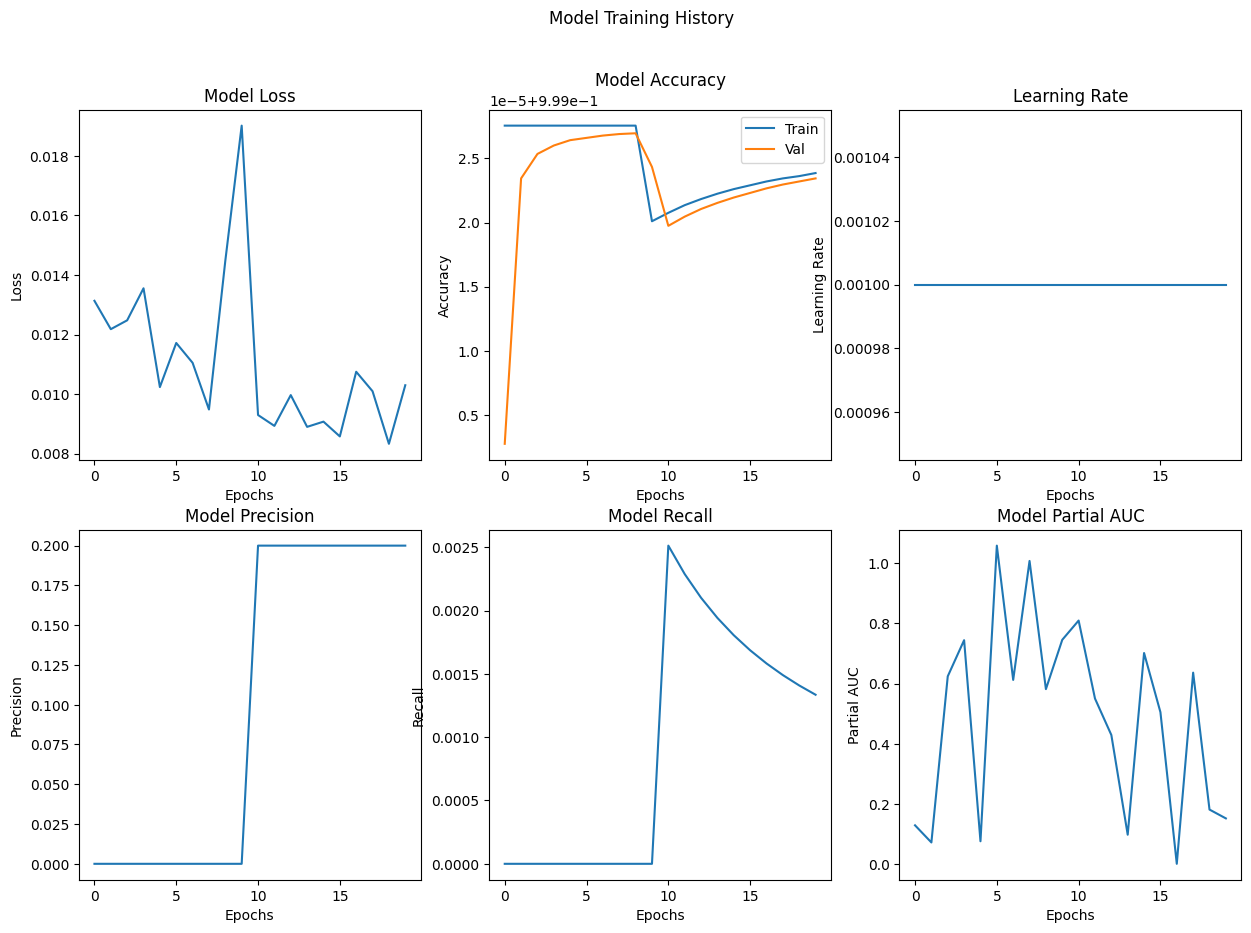

In [86]:
cnn.plot_history()